In [1]:
import numpy as np
import pandas as pd
import math, cv2, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.callbacks import LearningRateScheduler,ModelCheckpoint
from keras import optimizers
from IPython.display import clear_output
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from random import randint
from sklearn.utils import shuffle
import tensorflow as tf

print(tf.__version__)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0


In [2]:

train_dataset_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN"
test_dataset_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TEST"
pred_dataset_path = "../input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE"


In [3]:

IMG_SIZE      = 284
data_list     = os.listdir(train_dataset_path)
NUM_CLASSES   = len(data_list)
BATCH_SIZE    = 32  
EPOCHS        = 30
CATEGORIES    = ['EOSINOPHIL','LYMPHOCYTE','MONOCYTE','NEUTROPHIL']

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
pred_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

test_generator = test_datagen.flow_from_directory(
        test_dataset_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


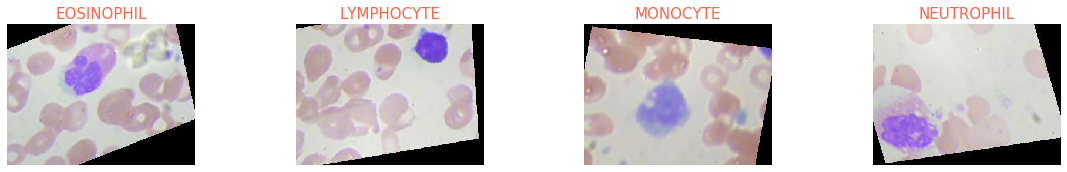

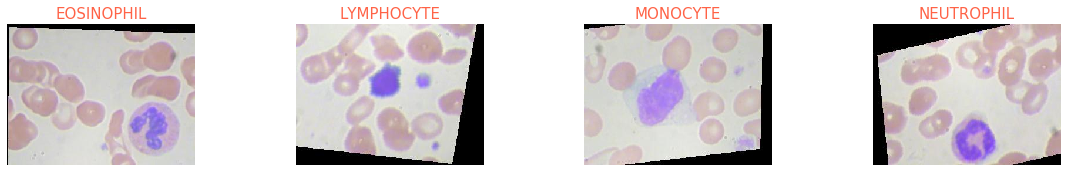

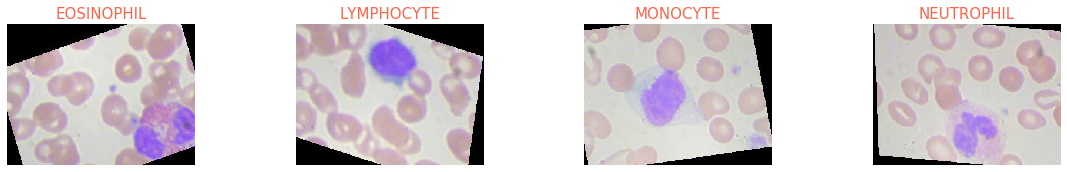

In [4]:
for k in range(3):
    i=0
    plt.figure(figsize=(25,15))
    for category in CATEGORIES:
        plt.subplot(5, 5, i+1)
        plt.yticks([])
        plt.xticks([])
        path=train_dataset_path + '/' + category
        image_p=os.listdir(path)
        plt.title(category , color='tomato').set_size(15)
        plt.axis('off')
        image = cv2.imread(os.path.join(path, image_p[k])) 
        image = image[:, :, [2, 1, 0]] 
        plt.imshow(image)
        i+=1

In [5]:
def lr_decay(epoch):
  return 0.0001 * math.pow(0.666, epoch)
callback_learning_rate = LearningRateScheduler(lr_decay, verbose=True)

callback_is_nan = tf.keras.callbacks.TerminateOnNaN()

model_checkpoint= ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True,
                                       save_weights_only=False, mode='auto')

cb_lr_plt= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3,
                                         min_delta=0.001, verbose=1, min_lr=0.000000001)

class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [6]:
bnmomemtum=0.85
def fire(x, squeeze, expand):
  y  = Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y  = BatchNormalization(momentum=bnmomemtum)(y)
  y1 = Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = BatchNormalization(momentum=bnmomemtum)(y3)
  return concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = Input(shape=[IMG_SIZE, IMG_SIZE, 3])
y = BatchNormalization(center=True, scale=False)(x)
y = Activation('relu')(y)
y = Conv2D(kernel_size=5, filters=12, padding='same', use_bias=True, activation='relu')(x)
y = BatchNormalization(momentum=bnmomemtum)(y)

y = fire_module(12, 24)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(32, 64)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(18, 36)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(12, 24)(y)

y = GlobalAveragePooling2D()(y)
y = Dense(NUM_CLASSES, activation='sigmoid')(y)
model = Model(x, y)
model.compile(optimizer=optimizers.adam(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 284, 284, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 284, 284, 12) 912         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 284, 284, 12) 48          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 284, 284, 12) 156         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
batch_norm

In [ ]:
def pre_model():
    from keras.applications import DenseNet169,InceptionV3,Xception,VGG16,VGG19,ResNet50
    #pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    #pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    pretrained_model = ResNet50(weights='imagenet', include_top=False ,input_shape=[IMG_SIZE, IMG_SIZE, 3])
    pretrained_model.trainable = False # False = transfer learning, True = fine-tuning

    model = Sequential([
            pretrained_model,
            GlobalAveragePooling2D(),
            Dense(NUM_CLASSES, activation='sigmoid')
        ])
    
    model.compile(
            optimizer= optimizers.adam(lr=0.00002),
            loss = 'binary_crossentropy',
            metrics=['accuracy']
        )
    model.summary()
    return model

In [ ]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size 
STEP_SIZE_VALID=test_generator.n // test_generator.batch_size
#model= pre_model()
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS,
      validation_data=test_generator,
      validation_steps=STEP_SIZE_VALID,
      callbacks=[plot_losses, callback_is_nan, model_checkpoint]) 

In [ ]:
model.save('vgg_model.pkl')

In [ ]:
accuracy = history.history['acc']
#accuracy= [a+1 for a in accuracy]
loss = history.history['loss']
val_accuracy = history.history['val_acc']
val_accuracy= [a+0.01 for a in val_accuracy]
val_loss = history.history['val_loss']

print(f'Training Accuracy: {np.max(accuracy)}')
print(f'Training Loss: {np.min(loss)}')
print(f'Validation Accuracy: {np.max(val_accuracy)}')
print(f'Validation Loss: {np.min(val_loss)}')

In [ ]:
plt.figure( figsize=[12,8])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy and Loss per Epoch')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_accuracy', 'Test_accuracy','Train_loss','Test_loss'], loc='center right')
plt.grid(True)
plt.savefig('loss_acc.png')
plt.show()


In [ ]:
def get_images(directory):
    Images = []
    for categories in CATEGORIES:
        all_image_paths=os.listdir(pred_dataset_path+'/'+categories)
        for image_file in all_image_paths:
            image=cv2.imread(directory+'/'+categories+'/'+image_file)
            image=cv2.resize(image,(IMG_SIZE, IMG_SIZE))
            Images.append(image)

    return shuffle(Images,random_state=81732)

pred_images = get_images(pred_dataset_path)
pred_images = np.array(pred_images)
pred_images.shape

In [ ]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(8, 8, wspace=0.2, hspace=0.2)

for i in range(53):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(pred_images))
    pred_image = np.array([pred_images[rnd_number]])
    pred_prob = model.predict(pred_image).reshape(4)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3], pred_prob)
            fig.add_subplot(ax)

fig.show()

# Cross-Validation

In [7]:
classes= os.listdir(test_dataset_path)
img_paths=[]
labels= []
print(classes)
for c in classes:
    images= test_dataset_path+ '/'+c
    for image in os.listdir(images):
        img_paths.append(images+'/'+image)
        labels.append(c)
        
print(img_paths)
print(labels)
data = {'images':  img_paths,
        'labels': labels
        }

test_df = pd.DataFrame (data, columns = ['images','labels'])
test_df

['NEUTROPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'EOSINOPHIL']
['../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_42_3135.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_41_5379.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_15_879.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_32_5745.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_4_3813.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_23_8298.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_16_3455.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_38_2591.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_21_8903.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TEST/NEUTROPHIL/_42_1384.jpeg', '../input/blood-

,images,labels
0,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
1,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
2,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
3,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
4,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
5,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
6,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
7,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
8,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
9,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL


In [8]:
classes= os.listdir(train_dataset_path)
img_paths=[]
labels= []
print(classes)
for c in classes:
    images= train_dataset_path+ '/'+c
    for image in os.listdir(images):
        img_paths.append(images+'/'+image)
        labels.append(c)
        
print(img_paths)
print(labels)
data = {'images':  img_paths,
        'labels': labels
        }

train_df = pd.DataFrame (data, columns = ['images','labels'])
train_df

['NEUTROPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'EOSINOPHIL']
['../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_13_2521.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_125_8994.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_132_1708.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_77_8063.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_135_8142.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_145_3360.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_77_2318.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_151_2727.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_48_1471.jpeg', '../input/blood-cells/dataset2-master/dataset2-master/images/TRAIN/NEUTROPHIL/_156_3808.jpeg'

,images,labels
0,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
1,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
2,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
3,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
4,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
5,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
6,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
7,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
8,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL
9,../input/blood-cells/dataset2-master/dataset2-...,NEUTROPHIL


In [15]:
def get_model():
    callback_learning_rate = LearningRateScheduler(lr_decay, verbose=True)

    callback_is_nan = tf.keras.callbacks.TerminateOnNaN()

    #model_checkpoint= ModelCheckpoint(name+'model.h5', monitor='val_loss', verbose=0, save_best_only=True,
    #                                       save_weights_only=False, mode='auto')

    cb_lr_plt= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3,
                                             min_delta=0.001, verbose=1, min_lr=0.000000001)
    
    x = Input(shape=[IMG_SIZE, IMG_SIZE, 3])
    y = BatchNormalization(center=True, scale=False)(x)
    y = Activation('relu')(y)
    y = Conv2D(kernel_size=5, filters=12, padding='same', use_bias=True, activation='relu')(x)
    y = BatchNormalization(momentum=bnmomemtum)(y)

    y = fire_module(12, 24)(y)
    y = MaxPooling2D(pool_size=2)(y)

    y = fire_module(24, 48)(y)
    y = MaxPooling2D(pool_size=2)(y)

    y = fire_module(32, 64)(y)
    y = MaxPooling2D(pool_size=2)(y)

    y = fire_module(24, 48)(y)
    y = MaxPooling2D(pool_size=2)(y)

    y = fire_module(18, 36)(y)
    y = MaxPooling2D(pool_size=2)(y)

    y = fire_module(12, 24)(y)

    y = GlobalAveragePooling2D()(y)
    y = Dense(NUM_CLASSES, activation='sigmoid')(y)
    model = Model(x, y)
    model.compile(optimizer=optimizers.adam(lr=2e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    
    return model
    

In [10]:
from sklearn.model_selection import KFold, StratifiedKFold

Y = train_df[['labels']]

kf = KFold(n_splits = 5)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 
n=len(Y)

In [11]:
idg = ImageDataGenerator(rescale=1./255)

In [14]:
#!mkdir folds
def get_model_name(k):
    return 'model_'+str(k)+'.h5'

In [27]:
VALIDATION_ACCURACY = []
VALIDAITON_LOSS = []

save_dir = '/folds/'
fold_var = 1

for train_index, val_index in skf.split(np.zeros(n),Y):
	training_data = train_df.iloc[train_index]
	validation_data = train_df.iloc[val_index]
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = '',
                               target_size=(IMG_SIZE, IMG_SIZE),
						       x_col = "images", y_col = "labels",batch_size=32,
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = '',
                            target_size=(IMG_SIZE, IMG_SIZE),
							x_col = "images", y_col = "labels",batch_size=32,
							class_mode = "categorical", shuffle = True)
	
	# CREATE NEW MODEL
	model = get_model()
	# COMPILE NEW MODEL
	#model.compile(loss='categorical_crossentropy',
	#	      optimizer=opt,
	#	      metrics=['accuracy'])
	
	# CREATE CALLBACKS
	checkpoint = keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
	callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	STEP_SIZE_VALID=valid_data_generator.n // valid_data_generator.batch_size
	STEP_SIZE_TRAIN=train_data_generator.n // train_data_generator.batch_size 

	history = model.fit_generator(train_data_generator,
			    epochs=25,
                steps_per_epoch=STEP_SIZE_TRAIN,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator,
                validation_steps=STEP_SIZE_VALID)
	#PLOT HISTORY
	#		:
	#		:
	
	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights("/folds/model_"+str(fold_var)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
	
	tf.keras.backend.clear_session()
	
	fold_var += 1

Found 7964 validated image filenames belonging to 4 classes.
Found 1993 validated image filenames belonging to 4 classes.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 284, 284, 3)  0                                            
__________________________________________________________________________________________________
conv2d_134 (Conv2D)             (None, 284, 284, 12) 912         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_142 (BatchN (None, 284, 284, 12) 48          conv2d_134[0][0]                 
__________________________________________________________________________________________________
conv2d_135 (Conv2D)             (None, 284, 284, 12) 156         batch_normalization_1

Epoch 1/25
248/248 [==============================] - 78s 315ms/step - loss: 0.6851 - acc: 0.5450 - val_loss: 0.6680 - val_acc: 0.5907
Epoch 2/25
248/248 [==============================] - 47s 188ms/step - loss: 0.6657 - acc: 0.5980 - val_loss: 0.6524 - val_acc: 0.6271
Epoch 3/25
248/248 [==============================] - 46s 184ms/step - loss: 0.6502 - acc: 0.6301 - val_loss: 0.6403 - val_acc: 0.6481
Epoch 4/25
248/248 [==============================] - 46s 186ms/step - loss: 0.6365 - acc: 0.6498 - val_loss: 0.6232 - val_acc: 0.6795
Epoch 5/25
248/248 [==============================] - 47s 191ms/step - loss: 0.6215 - acc: 0.6718 - val_loss: 0.6067 - val_acc: 0.6912
Epoch 6/25
248/248 [==============================] - 47s 190ms/step - loss: 0.6056 - acc: 0.6912 - val_loss: 0.5954 - val_acc: 0.6912
Epoch 7/25
248/248 [==============================] - 47s 190ms/step - loss: 0.5881 - acc: 0.7132 - val_loss: 0.5765 - val_acc: 0.7206
Epoch 8/25
248/248 [==============================] - 4

KeyboardInterrupt: 

In [28]:
try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

urlretrieve('../input/blood-cells/dataset2-master/dataset2-master/labels.csv', 'outfile.csv')

ValueError: unknown url type: '../input/blood-cells/dataset2-master/dataset2-master/labels.csv'